In [1]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import itertools
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.patches as patches
from scipy.stats.stats import pearsonr
from matplotlib import gridspec
%matplotlib inline

font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
matplotlib.rcParams['font.family'] = 'arial'

In [2]:
def make_heatmap_logged_vals(fig,ax,genes_grouped,expr_dataframe,samps,breaks=[7,9,17],xticks_=True,yticks_=True,
                             buff_=0.6,xbuff_=0.3,xbuffs=None,y_fontsize=10):
    
    colormap = cm.bwr
    normed_cmap = Normalize(vmin=-0.5, vmax=0.5)
    ax.yaxis.set_ticks_position('both')
    
    ## calculate zscores per gene per cluster (list ordered by ordered_clusters)
    zscores_per_gene = {}
    logged_vals = {}
    for gene,group in genes_grouped:
        log_expr_vals_arr = np.log(np.array(expr_dataframe[samps].loc[gene].values)+1)/np.log(2)
        mean_vals = np.mean(log_expr_vals_arr)
        std_dev = np.std(log_expr_vals_arr)
        logged_vals[gene] = (log_expr_vals_arr - min(log_expr_vals_arr))/(max(log_expr_vals_arr) - min(log_expr_vals_arr)) - 0.5
        zscores_per_gene[gene] = (log_expr_vals_arr-mean_vals)/std_dev
    
    prev_group = genes_grouped[0][1]
    buff = 0
    xbuff = 0
    yticks = []
    region_ticks = []
    region_labs = []
    grp_cnt = 0
    xticks = []
    for j,(gene,group) in enumerate(genes_grouped):
        if group != prev_group: 
            #plt.axhline(-j-buff+0.5,color='black',linewidth=1)
            #plt.axhline(-j-buff-0.5,color='black',linewidth=1)
            region_ticks.append(-j-buff+(grp_cnt+1)/2.)
            region_labs.append(prev_group)
            buff += buff_
            grp_cnt = 0
            prev_group = group
        grp_cnt += 1
        xbuff = 0
        xbuff_iter=0
        for k,samp in enumerate(samps):
            val = logged_vals[gene][k]
            color = tuple(np.array(colormap(normed_cmap(val),bytes=True))/255.)
            p = patches.Rectangle((k+xbuff-1/2.,-j-1/2.-buff), 1, 1, fill=True, 
                                  facecolor=color, linestyle='-',edgecolor='black')
            ax.add_patch(p)
            xticks.append(j+xbuff)
            if k in breaks:
                if xbuffs is not None:
                    xbuff+=xbuffs[xbuff_iter]
                else:
                    xbuff+=0.3
                xbuff_iter+=1
        yticks.append(-j-buff)
    
    buff+=1
    region_ticks.append(-j-buff+(grp_cnt+1)/2.)
    region_labs.append(prev_group)
    
    if yticks_ == True:
        plt.yticks(yticks,[x[0] for x in genes_grouped],fontsize=y_fontsize)
    else:
        plt.yticks([])
    xticks = []
    xbuff = 0
    xbuff_iter=0
    for x in range(len(samps)):
        xticks.append(x+xbuff)
        if x in breaks:
            if xbuffs is not None:
                xbuff+=xbuffs[xbuff_iter]
            else:
                xbuff+=0.3
            xbuff_iter+=1
    
    if xticks_ == True:
        plt.xticks(xticks,samps,fontsize=16,rotation=90)
    else:
        plt.xticks([])
        
    plt.xlim(-0.5,k+0.5+xbuff)
    plt.ylim(-j+0.5-buff,0.5)
    
    if yticks_ == True:
        ax.yaxis.set_ticks_position("left")
        ax2 = ax.twinx()
        plt.yticks(region_ticks,region_labs,fontsize=y_fontsize)
        plt.ylim(-j+0.5-buff,0.5)
        ax2.yaxis.set_ticks_position("left")
        ax.yaxis.set_ticks_position("right")
    else:
        plt.yticks([])
        plt.xlim(-0.5,k+0.5+xbuff+0.1)
    
    if xticks_ == False:
        plt.ylim(-j+0.4-buff,0.5)
    
    return fig

In [3]:
expr_dat = {}
with open('/mnt/e/MPIMG/Elkabetz/notebooks/Mutukula_etal_Revision/data/org_expr_table.tsv','r') as expr_fn:
    for i,row in enumerate(expr_fn):
        spl = row.strip("\n").split("\t")
        if i == 0:
            header = spl
            for head in header[1:]:
                expr_dat[head] = {}
            continue
        gene = spl[0]
        for j in range(1,len(header)):
            expr_dat[header[j]][gene] = float(spl[j])

In [4]:
expr_dat.keys()

dict_keys(['ESC_1', 'ESC_2', 'ESC_3', 'Day17_WT_Inhibitor-free', 'Day17_WT_WNT-i', 'Day17_WT_Dual SMAD-i', 'Day17_WT_Triple-i', 'Day17_ho_Inhibitor-free', 'Day17_ho_WNT-i', 'Day17_ho_Dual SMAD-i', 'Day17_ho_Triple-i', 'Day17_he_Inhibitor-free', 'Day17_he_WNT-i', 'Day17_he_Dual SMAD-i', 'Day17_he_Triple-i', 'Day30_WT_Inhibitor-free', 'Day30_WT_WNT-i', 'Day30_WT_Dual SMAD-i', 'Day30_WT_Triple-i', 'Day30_ho_Inhibitor-free', 'Day30_ho_Dual SMAD-i', 'Day30_ho_Triple-i', 'Day30_he_Inhibitor-free', 'Day30_he_Dual SMAD-i', 'Day30_he_Triple-i', 'Day30_WT_Inhibitor-free_1', 'Day30_WT_Inhibitor-free_2', 'Day30_WT_Inhibitor-free_3', 'Day30_WT_Inhibitor-free_4', 'Day30_WT_Inhibitor-free_5', 'Day30_WT_Inhibitor-free_6', 'Day30_WT_Inhibitor-free_7', 'Day30_WT_Inhibitor-free_8', 'Day30_WT_WNT-i_1', 'Day30_WT_WNT-i_2', 'Day30_WT_Dual SMAD-i_1', 'Day30_WT_Dual SMAD-i_2', 'Day30_WT_Dual SMAD-i_3', 'Day30_WT_Dual SMAD-i_4', 'Day30_WT_Dual SMAD-i_5', 'Day30_WT_Dual SMAD-i_6', 'Day30_WT_Dual SMAD-i_7', 'Day

In [5]:
samp_order = []
for i in range(1,9): samp_order.append('Day30_WT_Inhibitor-free_'+str(i))
#for i in range(1,3): samp_order.append('Day30_WT_WNT-i_'+str(i))
for i in [5,1,2,3,4,6,7,8]: samp_order.append('Day30_WT_Dual SMAD-i_'+str(i))
for i in [4,1,2,3,5,6,7,8]: samp_order.append('Day30_WT_Triple-i_'+str(i))

genes_grouped = []
for gene in ['SOX1','FABP7','DLL1','HES5','NOTCH1','NES','SOX2']:
    genes_grouped.append((gene,'Neural\nstem cell'))
for gene in ['DLX1','DLX2','DLX5','DLX6','GSX2','ARX']:
    genes_grouped.append((gene,'Subpallium'))
for gene in ['FOXG1','SP8','EMX1','PAX6','SFRP1','LHX2','SIX3','EOMES','NEUROD6','TBR1','MEF2C']:
    genes_grouped.append((gene,'Neocortex'))
for gene in ['EMX2','NR2F1','TCF4','LEF1','RSPO1','RSPO2','RSPO3','LMX1A','FOXJ1','TTR','WNT2B','WNT7B']:
    genes_grouped.append((gene,'Medial Palium'))
for gene in ['TCF7L2','GBX2','FZD10','IRX2','IRX3','PROX1','OLIG3','SHOX2','ZIC1','ZIC2']:
    genes_grouped.append((gene,'Diencephalon'))
for gene in ['PAX3','DMBX1','DBX1','EN2','HOXA2','HOXB2','HOXB3','PAX7','PHOX2B','WNT1','BARHL1','ATOH1']:
    genes_grouped.append((gene,'Mid/Hindbrain'))

In [6]:
pd_dict = {}
for samp in samp_order:
    pd_dict[samp] = [expr_dat[samp][x] for x in [y[0] for y in genes_grouped]]
    
expr_dataframe=pd.DataFrame.from_dict(pd_dict)#,columns=[y[0] for y in genes_grouped])
expr_dataframe.index = [y[0] for y in genes_grouped]

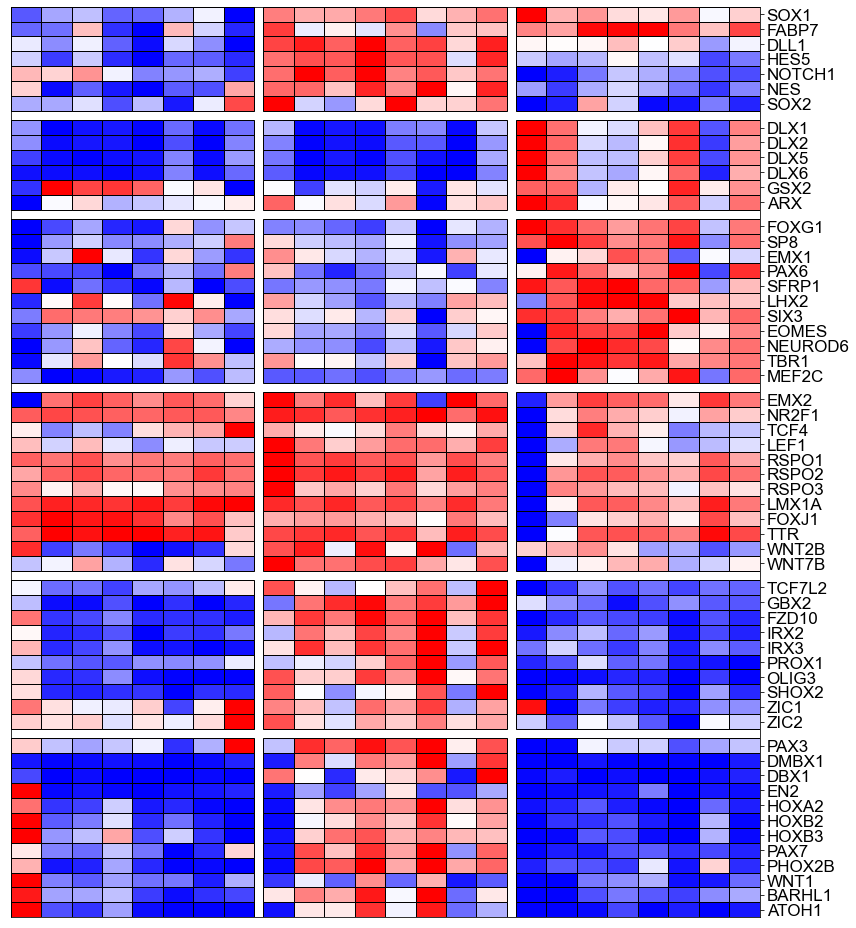

In [7]:
fig = plt.figure(figsize=(12,13))
ax = plt.subplot(111)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
fig = make_heatmap_logged_vals(fig,ax,genes_grouped,expr_dataframe,samp_order,breaks=[7,15],
                              y_fontsize=17)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('figures/fig1/d30_heatmap.pdf',bbox_inches='tight')
plt.savefig('figures/fig1/d30_heatmap.png',bbox_inches='tight',dpi=500)

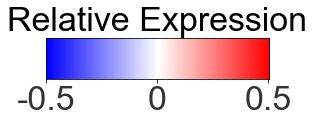

In [8]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.figure(figsize=(4,1.5))
ax=plt.subplot(111)
plt.xticks([x/2.*255 for x in range(0,3)],[-0.5,0,0.5],fontsize=34, alpha=0.8)
plt.yticks([])
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('bwr'))
plt.gcf().subplots_adjust(bottom=0.5)
plt.title('Relative Expression',fontsize=34)
plt.savefig('figures/fig1/d30_heatmap_colorbar_fig1g.png',dpi=500,bbox_inches='tight')

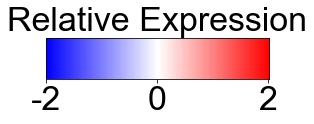

In [9]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.figure(figsize=(4,1.5))
ax=plt.subplot(111)
plt.xticks([x/2.*255 for x in range(0,3)],[-2,0,2],fontsize=34)
plt.yticks([])
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('bwr'))
plt.gcf().subplots_adjust(bottom=0.5)
plt.title('Relative Expression',fontsize=34)
plt.savefig('figures/fig1/d30_heatmap_colorbar_fig1h.png',dpi=500,bbox_inches='tight')

In [10]:
samp_order = []
for i in range(1,9): samp_order.append('Day30_WT_Inhibitor-free_'+str(i))
#for i in range(1,3): samp_order.append('Day30_WT_WNT-i_'+str(i))
for i in range(1,9): samp_order.append('Day30_WT_Dual SMAD-i_'+str(i)) #[5,1,2,3,4,6,7,8]
for i in [4,1,2,3,5,6,7,8]: samp_order.append('Day30_WT_Triple-i_'+str(i))

In [11]:
pd_dict = {}
for samp in samp_order:
    pd_dict[samp] = [expr_dat[samp][x] for x in [y[0] for y in genes_grouped]]
    
expr_dataframe=pd.DataFrame.from_dict(pd_dict)
expr_dataframe.index = [y[0] for y in genes_grouped]

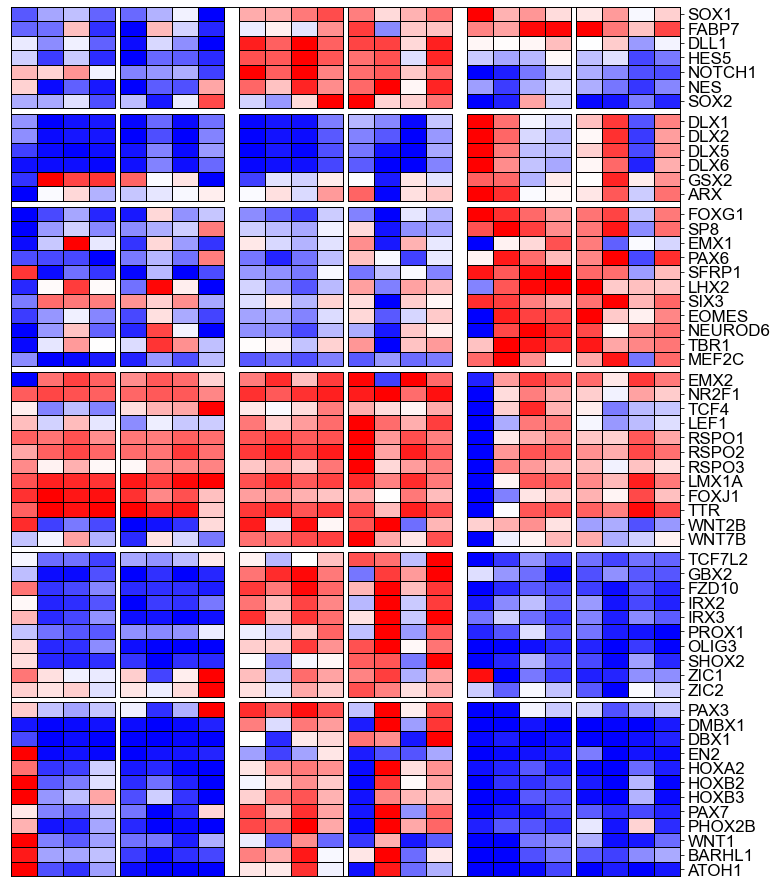

In [16]:
fig = plt.figure(figsize=(12,16))
ax = plt.subplot(111)
fig = make_heatmap_logged_vals(fig,ax,genes_grouped,expr_dataframe,samp_order,breaks=[3,7,11,15,19],buff_=0.4,
                               xbuffs=[0.2,0.6,0.2,0.6,0.2],y_fontsize=17)
plt.xticks([])
plt.yticks([])
plt.savefig('figures/suppfig1/d30_heatmap.sep_batch.pdf',bbox_inches='tight')
plt.savefig('figures/suppfig1/d30_heatmap.sep_batch.png',bbox_inches='tight',dpi=500)

In [17]:
samp_order = ['Day30_WT_Inhibitor-free','Day30_WT_WNT-i',
             'Day30_WT_Dual SMAD-i','Day30_WT_Triple-i']

In [18]:
pd_dict = {}
for samp in samp_order:
    pd_dict[samp] = [expr_dat[samp][x] for x in [y[0] for y in genes_grouped]]
    
expr_dataframe=pd.DataFrame.from_dict(pd_dict)
expr_dataframe.index = [y[0] for y in genes_grouped]

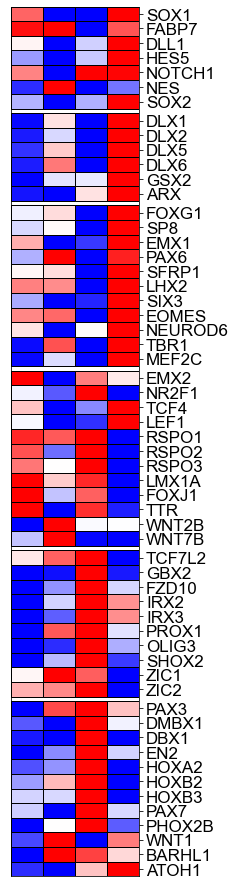

In [19]:
fig = plt.figure(figsize=(2.3,16))
ax = plt.subplot(111)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
fig = make_heatmap_logged_vals(fig,ax,genes_grouped,expr_dataframe,samp_order,breaks=[],buff_=0.3,xbuff_=0.2,
                              y_fontsize=17)

plt.xticks([])
plt.yticks([])
plt.savefig('figures/suppfig1/d17_heatmap.pdf',bbox_inches='tight')
plt.savefig('figures/suppfig1/d17_heatmap.png',bbox_inches='tight',dpi=500)